In [1]:
%run ../notebook_preamble.ipy

import seaborn as sns
import pymc3 as pm
import scipy.stats as ss
import theano.tensor as tt
from snepits.models.pymc_wrapper import PymcWrapper, PymcWrapperGrad

from pymc3.step_methods import SMC

# Specifying a household model

`Model` and `Population` are two abstract base classes.

* `Model` implements behaviour for a households model.
* `Population` implements behaviour for a population of households.



To create a new model all we need to do is subclass these classes and a few methods that specify the behaviour and attributes of our model...

## Individual Household

In [189]:
from snepits.models.models_meta import Model

class SIS(Model):
    """ SIS model class.

    Attributes:
        param_l (list[str]): Name of parameters
        demog_l (list[str]): Name of risk levels
        dim (int): Number of parameters
        sparse (bool): If True use sparse solver


    Args:
        N (int): Population size
        params (tuple): Model parameters (beta, eps)
            beta - Within population transmission rate
            eps - External Force of infection
        freq_dep (bool, optional): Frequency dependent transmission if True
    """

    param_l = ["beta", "eps", "alpha"]  # The names of the parameters of our model
    demog_l = ["N"]  # Names of the 
    R = 1  # Number of infectious stages in our model
    dim = len(param_l)
    sparse = False  # Whether to use a sparse or dense solver

    def gen_mat(self):
        """
        Generate transition matrix `M` of model for parameters based on
        attributes named in `self.param_l`.
        """
        N = self.N
        beta = self.beta
        alpha = self.alpha
        if self.freq_dep:
            beta *= 1 / (N - 1) ** alpha
        eps = self.eps

        x = np.arange(N + 1)
        self.M = np.diag(x[1:], k=1) + np.diag(
            (N - x[:-1]) * (beta * x[:-1] + eps), k=-1
        )
        self.M[x, x] = -self.M.sum(axis=0)
        return self.M

    def __str__(self):
        """ A nice string representation when we `print` """
        return f"SIS: N = {self.N}. Params: {[(k,v) for k,v in zip(self.param_l, self.params)]}" % (self.N)
    

In [193]:
params = np.array([3, .5, 0.2])  # beta, eps, alpha
HH_size = np.array([4])  # HH size, length same as demog_l
m = SIS(HH_size, params)
print(m)

2020-02-14 10:23:10,898 - root - INFO - seed: 519553
SIS: N = 4. Params: [('beta', 3.0), ('eps', 0.5), ('alpha', 0.2)]


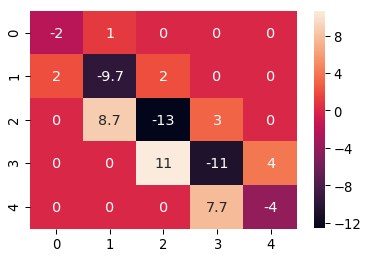

In [194]:
sns.heatmap(m.M, annot=True)  # Transition matrix

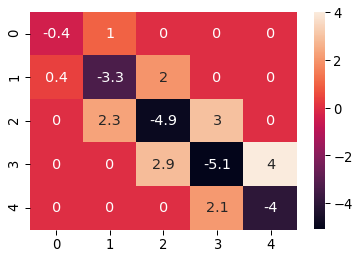

In [195]:
# Update and re-generate transition matrix
m.param_update([2, .1, 1])
m.gen_mat();

sns.heatmap(m.M, annot=True)  # Transition matrix

Text(0, 0.5, 'Probability')

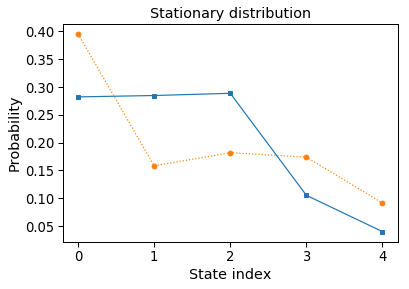

In [196]:
plt.plot(m.p, 's-')  # Original stationary distribution
plt.plot(m.get_sol(), 'o:')  # Resolved for new transition matrix
plt.title('Stationary distribution')
plt.xlabel('State index')
plt.ylabel('Probability')

## Collection of Households (`Model`s)

Now we want a collection of different sized households and to be able to operate on them as one - share the same transmission parameters, calculate the log-likelihood across all households etc.

In [197]:
from snepits.models.models_meta import Population

class SIS_pop(Population):
    """ SIS_pop model class.

    Attributes:
        subclass (obj): Class of sub_pops
        param_l (list[str]): Name of parameters
        demog_l (list[str]): Name of risk classes
        dim (int): Number of parameters

    Args:
        sizes (numpy.array): Array of population sizes for each class.
            One row per household, one column per class.
        params (tuple): Model parameters (beta, eps)
            beta - Within population transmission rate
            eps - External Force of infection
        freq_dep (bool, optional): Frequency dependent transmission if True
        data (numpy.array, optional): Array of numbers infected for each class
            One row per household, one column per class.
    """

    subclass = SIS  # Specify what type of `Model` this contains
    param_l = subclass.param_l  # Get the parameters of the subclass
    demog_l = subclass.demog_l  # Get from subclass
    dim = len(param_l)
    R = subclass.R

    def data_transform(self, data):
        """ Method to go from matrix index to infectious state index """
        return data  # SIS state and integer index are just the same

    def __str__(self):
        return "SIS_pop: %d households, total population = %d" % (self.m, self.N)

In [212]:
HH_sizes = np.array([4, 4, 2])
pop = SIS_pop(HH_sizes, params)
print(pop)

# There are three households but only two sub populations because only
# two are unique. This avoids repeating expensive likelihood evaluations.
# `Population` internally tracks duplicates and calculates
# likelihoods and other operations accordingly
print(f"Number of unique sub-populations: {len(pop.sub_pops)}")

2020-02-14 10:25:24,218 - root - INFO - seed: 496382
2020-02-14 10:25:24,219 - root - INFO - seed: True
2020-02-14 10:25:24,219 - root - INFO - seed: True
SIS_pop: 3 households, total population = 10
Number of unique sub-populations: 2


In [213]:
pop.calc_LL()  # Log likelihood

-3.71584998369041

In [214]:
# Update all sub-pops and get new likelihood
pop.param_update([1, 1, 1])
pop.calc_LL()

-3.7815049253565967

In [215]:
pop.calc_grad(recalc=True)  # Get gradient of log-likelihood (all sub-pops to be resolved)

array([ 0.12109531, -0.21561646, -0.35276156])

# Inference w/ pymc3

## Specify model using pymc wrapper

In [259]:
def model_to_pymc(model):
    """ """
    with pm.Model() as pm_model:

        beta = pm.HalfNormal("beta", sd=5)
        eps = pm.Uniform("eps", lower=0.0, upper=10.0)
        alpha = pm.Uniform("alpha", lower=0.0, upper=1.0)
        
        # Could specify a parameter as constant
        # alpha = pm.Constant("alpha", 1.)

        # theta should correspond to `model.params`
        theta = tt.as_tensor_variable([beta, eps, alpha])
        
        # Use `PymcWrapper` to use `model` for likelihood
        loglike = PymcWrapper(model)
        pm.Potential("likelihood", loglike(theta))
    return pm_model



## Inference on artificially generated data

2020-02-14 10:40:33,683 - root - INFO - seed: 490612
2020-02-14 10:40:33,684 - root - INFO - seed: True
2020-02-14 10:40:33,888 - pymc3 - INFO - Auto-assigning NUTS sampler...
2020-02-14 10:40:33,888 - pymc3 - INFO - Initializing NUTS using jitter+adapt_diag...
2020-02-14 10:40:34,378 - pymc3 - INFO - Multiprocess sampling (4 chains in 4 jobs)
2020-02-14 10:40:34,379 - pymc3 - INFO - NUTS: [alpha, eps, beta]


Sampling 4 chains: 100%|██████████| 6000/6000 [00:37<00:00, 159.99draws/s]


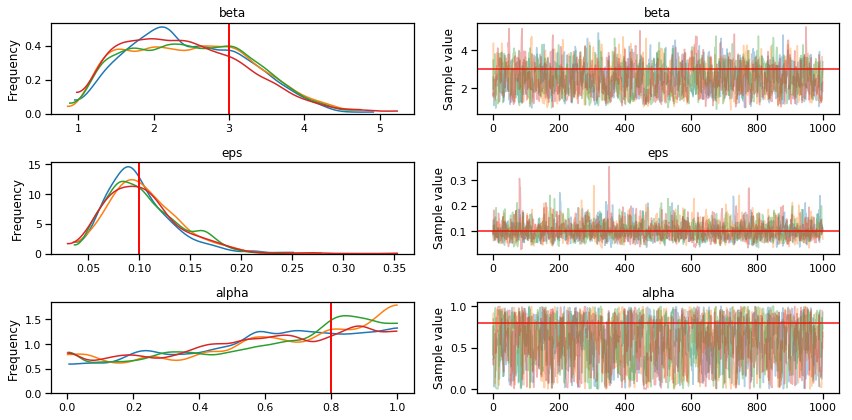

In [260]:
# Data generated from true parameters (`params`) by inverse sampling
sizes = np.ones(100, dtype=np.int) * 4  # Household sizes
params = np.array([3, 0.1, 0.8])  # "true" parameters
model = SIS_pop(sizes=sizes, params=params, data=None)

pm_model = model_to_pymc(model)

with pm_model:
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

lines = {
    "beta": model.t_params[0],
    "eps": model.t_params[1],
    "alpha": model.t_params[2],
}
_ = pm.traceplot(trace, lines=lines)

In [304]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,2.471677,0.799852,0.024483,1.137187,3.933528,1135.333481,0.999902
eps,0.102276,0.034921,0.000801,0.044964,0.172093,1777.798960,1.001484
alpha,0.572274,0.284107,0.008614,0.070922,0.999508,1107.077814,1.000344


## Inference on "real" data

In [89]:
# Data input directly
sizes # Household sizes (defined earlier)
params  # initial parameters (defined earlier)
data = np.array([np.random.randint(low=0, high=s+1) for s in sizes])

model2 = SIS_pop(
    sizes=sizes,
    params=params,
    data=data,
)

pm_model2 = model_to_pymc(model2)

with pm_model2:
    trace2 = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

_ = pm.traceplot(trace2)

2020-02-14 09:40:32,819 - root - INFO - seed: 430428
2020-02-14 09:40:32,820 - root - INFO - seed: True


## Other sampling methods

In [273]:
# We can even use Sequential Monte Carlo (SMC)!
with pm_model:
    trace_SMC = pm.sample(step=SMC(), draws=1000, chains=4)

2020-02-14 10:46:03,333 - pymc3 - INFO - Sample initial stage: ...
2020-02-14 10:46:03,922 - pymc3 - INFO - Stage: 0 Beta: 0.012482 Steps: 25


100%|██████████| 1000/1000 [00:07<00:00, 131.26it/s]


2020-02-14 10:46:11,813 - pymc3 - INFO - Stage: 1 Beta: 0.032558 Steps: 10


100%|██████████| 1000/1000 [00:03<00:00, 325.75it/s]


2020-02-14 10:46:15,155 - pymc3 - INFO - Stage: 2 Beta: 0.081192 Steps: 3


100%|██████████| 1000/1000 [00:00<00:00, 1074.19it/s]


2020-02-14 10:46:16,349 - pymc3 - INFO - Stage: 3 Beta: 0.203460 Steps: 8


100%|██████████| 1000/1000 [00:02<00:00, 407.51it/s]


2020-02-14 10:46:19,066 - pymc3 - INFO - Stage: 4 Beta: 0.596453 Steps: 4


100%|██████████| 1000/1000 [00:01<00:00, 825.02it/s]


2020-02-14 10:46:20,541 - pymc3 - INFO - Stage: 5 Beta: 1.000000 Steps: 7


100%|██████████| 1000/1000 [00:02<00:00, 467.21it/s]


In [280]:
# Or Variational inference!
def ADVI_until_conv(pm_model, converge, limit=100_000):
    """ FullRankADVI inference until either `converge` is met or `limit` exceeded """
    with pm_model:
        inference = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval, std=inference.approx.std.eval
        )
        callbacks = [tracker, converge]
        approx = pm.fit(n=limit, method=inference, callbacks=callbacks)
    return approx, inference, tracker


# Run ADVI until the means and stdevs are within 0.01 relative diff
converge = pm.callbacks.CheckParametersConvergence(tolerance=0.005, diff="relative")
approx, _, tracker = ADVI_until_conv(pm_model, converge)

# Draw 500 samples from the ADVI approximation
trace_VI = approx.sample(draws=500)

# Plot ADVI convergence
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
ax[0].plot(approx.hist)
ax[0].set_ylabel('Negative ELBO')
ax[1].plot(tracker['mean'])
ax[1].set_ylabel('Mean track')
ax[2].plot(tracker['std'])
ax[2].set_ylabel('S.D. track')
fig.tight_layout()
fig.suptitle('ADVI convergence', y=1.01)

Average Loss = 159.84:  51%|█████     | 50688/100000 [01:16<01:14, 664.51it/s]

2020-02-14 10:50:05,576 - pymc3.variational.inference - INFO - Convergence achieved at 50700
2020-02-14 10:50:05,577 - pymc3.variational.inference - INFO - Interrupted at 50,699 [50%]: Average Loss = 175.1


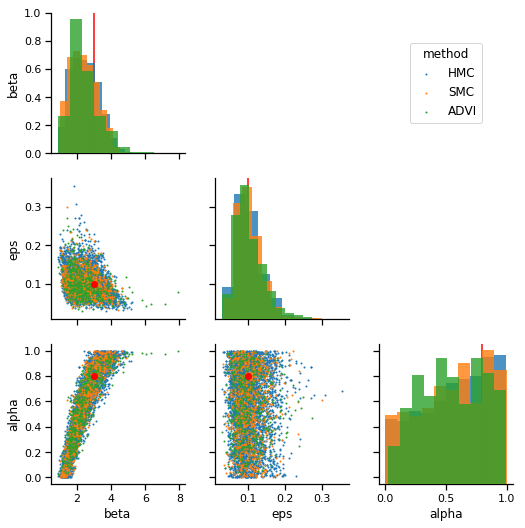

In [302]:
trace_pairplot(
    [trace, trace_SMC, trace_VI],
    diag_kind="hist",
    s=1,
    t_params=model.t_params,
    labels=["HMC", "SMC", "ADVI"],
)

# More general models

`SIS_AR_gen` implements a function that generates a general transition matrix given a model specification.

This functions generality makes it incredibly inefficient. It's better to write an optimised function for each model specification if you plan on using it for inference.

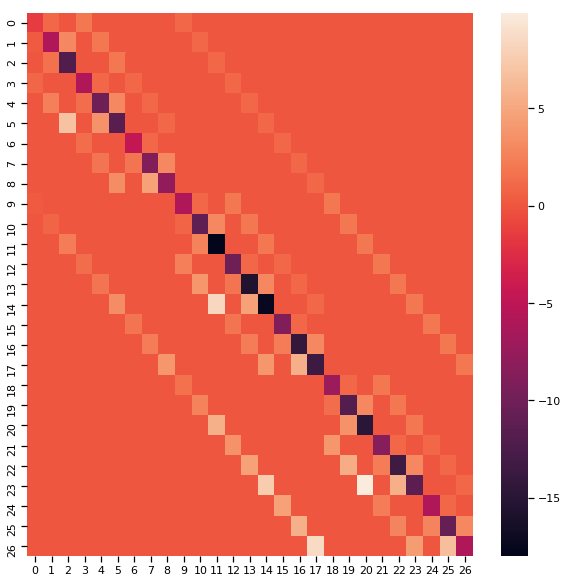

In [249]:
from snepits.pyovpyx import SIS_AR_gen

A, R = 3, 2  # Number of Demographic and infection levels

# Model parameters
beta = np.array([
    [0, 1, 2],
    [0, 2, 3],
    [0, 1, 4],
], dtype=np.double).T
gamma = np.array([
    [0, 1, 2],
    [0, 2, 1],
    [0, 1, 3],
], dtype=np.double).T
rho = np.array([
    [1, 2, 0],
    [3, 1, 0],
    [1, 2, 0],
], dtype=np.double).T
eps = 0.3
alpha = 1

cf = 10  # Sparse compression factor - increase if errors encountered

Ntup = np.array([1, 1, 1], dtype=np.int)  # Household population size

# Generate transition matrix
M = SIS_AR_gen(A, R, Ntup, beta, gamma, rho, eps, alpha, cf)

# Visualise
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(10, 10))
annot = True if M.shape[0] < 30 else False
sns.heatmap(M.todense(), annot=False, ax=ax)

`data_transform` can be implemented using `el_f_gen` (see `MC_indexing` notebook)

In [252]:
from pyovpyx import el_f_gen, idx_to_state

state = np.array([1, 0, 0, 0, 0, 1], dtype=int)  # length: A * R
idx = el_f_gen(Ntup, state)
print(f"{state} -> {idx}")

assert np.all(state == idx_to_state(idx, A, R, Ntup))

[1 0 0 0 0 1] -> 11
